In [8]:
sessionData = {'date': ["1/1/17","1/2/17","1/3/17","1/4/17","1/5/17","1/6/17","1/7/17","1/8/17","1/9/17","1/10/17",
"1/11/17","1/12/17","1/13/17","1/14/17","1/15/17","1/16/17","1/17/17","1/18/17","1/19/17","1/20/17",
"1/21/17","1/22/17","1/23/17","1/24/17","1/25/17","1/26/17","1/27/17","1/28/17","1/29/17","1/30/17",
"1/31/17","2/1/17","2/2/17","2/3/17","2/4/17","2/5/17","2/6/17","2/7/17","2/8/17","2/9/17","2/10/17",
"2/11/17","2/12/17","2/13/17","2/14/17","2/15/17","2/16/17","2/17/17","2/18/17","2/19/17","2/20/17",
"2/21/17","2/22/17","2/23/17","2/24/17","2/25/17","2/26/17","2/27/17","2/28/17","3/1/17","3/2/17","3/3/17",
"3/4/17","3/5/17","3/6/17","3/7/17","3/8/17","3/9/17","3/10/17","3/11/17","3/12/17","3/13/17","3/14/17",
"3/15/17","3/16/17","3/17/17","3/18/17","3/19/17","3/20/17","3/21/17","3/22/17","3/23/17","3/24/17",
"3/25/17","3/26/17","3/27/17","3/28/17","3/29/17","3/30/17","3/31/17","4/1/17","4/2/17","4/3/17",
"4/4/17","4/5/17","4/6/17","4/7/17","4/8/17","4/9/17","4/10/17"],
     'sessions': [88215,88484,87877,86780,84622,84607,84362,84912,84367,85991,86562,86761,85735,85386,84023,
83504,83795,85127,84971,86433,88094,89120,89184,90188,88540,88693,88031,86601,87447,87716,87042,87039,
86197,84339,85095,84764,83386,82621,83256,82997,84614,84480,86006,86436,85711,84115,83612,84812,85036,
84844,83745,85598,84914,85813,86634,86995,88356,87731,89142,90383,90686,93692,93800,93502,93786,92292,
91104,90193,90341,89314,88861,88853,89992,90246,90968,89741,88718,88335,87898,87666,88600,90110,90401,
90370,90346,89691,90643,90489,91289,89290,88668,89804,88989,89976,88239,87444,86951,85434,85655,
85105]}

sessionsDf = pd.DataFrame(data = sessionData)

/Users/LianshuiZhao/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


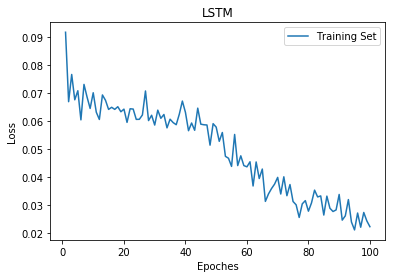

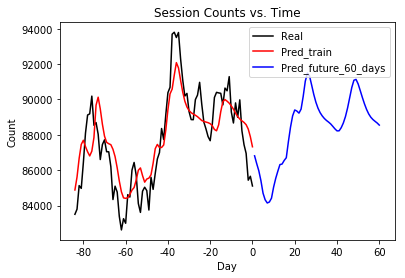

We can see that the predictions of the future 60 days is similar to the trend in the last 60 days.


In [13]:
#My answer to Q.4
#======= Load the libraries ===========
#initialize the random seed to allow repeatability of the results
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#Use sliding window method to construct the data for LSTM
data_lstm = sessionsDf.iloc[:, 1:2].values
data_train = data_lstm
                         
#feature scaling
sc = MinMaxScaler(feature_range = (0, 1))
#sc = StandardScaler()

training_set_scaled = sc.fit_transform(data_train)

#construct the data set for LSTM
def data_format(data, num_base):
    x = []
    y = []
    for i in range(num_base, data.shape[0]):
        x.append(data[i-num_base:i, 0])
        y.append(data[i, 0])
    x, y = np.array(x), np.array(y)
    x = x.reshape((x.shape[0], x.shape[1], 1))
    return x, y

num_base = 15 #number of points used as input
x_train, y_train = data_format(training_set_scaled, num_base)

#Construct and Fit the LSTM
def build_regressor(_optimizer, x_train):
    #Initialise
    regressor = Sequential()
    
    #1st LSTM layer and some dropout regularization
    regressor.add(LSTM(units=20, return_sequences=True, input_shape = (x_train.shape[1], 1)))
    regressor.add(Dropout(0.2))
    
    #intermediate LSTM layers and dropout regularization
    for i in range(6): #more LSTM? 
        regressor.add(LSTM(units=20, return_sequences=True))
        regressor.add(Dropout(0.2))

    #last LSTM layer and dropout regularization
    regressor.add(LSTM(units=20))
    regressor.add(Dropout(0.2))
    
    #output layer
    regressor.add(Dense(units=1))
    
    #compile
    regressor.compile(optimizer=_optimizer, loss = 'mean_squared_error') 
    
    return regressor

regressor = build_regressor('rmsprop', x_train)

#if you get the following error message when fitting
#OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
#OMP: Hint: This means that multiple copies of the OpenMP runtime have been linked into the program. That is dangerous, since it can degrade performance or cause incorrect results. The best thing to do is to ensure that only a single OpenMP runtime is linked into the process, e.g. by avoiding static linking of the OpenMP runtime in any library. As an unsafe, unsupported, undocumented workaround you can set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, but that may cause crashes or silently produce incorrect results. For more information, please see http://www.intel.com/software/products/support/.
#execute the following two lines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#fit the regressor
epos = 100 #number of epoches
history = regressor.fit(x_train, y_train, epochs=epos, batch_size=3, verbose=0)

#Predict and Visualize
#predict
y_pred_train = regressor.predict(x_train)
y_pred_train = sc.inverse_transform(y_pred_train)
#round y_pred to the nearest integers
for i in range(y_pred_train.shape[0]):
    for j in range(y_pred_train.shape[1]):
        y_pred_train[i, j] = int(y_pred_train[i, j]+0.5)
        
#visualize
num_epoches = len(history.history['loss'])
plt.plot (range(1, 1+epos), history.history['loss'], label = 'Training Set')
plt.title('LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoches')
plt.legend()
plt.show()

#make predictions for the future num_fut_days (60) days
def predict_num_days (data, num_fut_days): #raw data, not scaled (data_train)
    #choose the last num_base of points as the initial input data
    pred = [] #un-scaled value
    data_input = list(data[-num_base:][:, 0]) #unscaled value
    
    for i in range(num_fut_days):
        inpt = sc.transform(np.array(data_input[-num_base:]).reshape((-1, 1))) #take the existing predictions as part of the input.
        inpt = inpt.reshape((inpt.shape[1], inpt.shape[0], 1))
        pred_one_day = sc.inverse_transform(regressor.predict(inpt)).item() #extract the value
        pred.append(pred_one_day)
        data_input.append(pred_one_day)
    return pred

num_fut_days = 60
pred_fut_days = predict_num_days(data_lstm, num_fut_days)
for i in range(len(pred_fut_days)):
    pred_fut_days[i] = int(pred_fut_days[i]+0.5)

#plot the real counts in the training set, the predicted counts in the training set, and the predicted counts in the future 60 days.
y_train_sc_reverse = sc.inverse_transform(y_train.reshape(-1, 1))

plt.plot(range(1+num_base, 1+100), y_train_sc_reverse, color = 'k', label = 'Real') #real counts
plt.plot(range(1+num_base, 1+100), y_pred_train, color = 'r', label = 'Pred_train') #predicted counts in training sets
plt.plot(range(101, 101+num_fut_days), pred_fut_days, color = 'b', label = 'Pred_future_60_days') #predicted counts in the future 60 days
plt.title('Session Counts vs. Time')
plt.xticks(range(20, 180, 20), labels = [str(i)for i in range(20-100, 180-100, 20)])
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend()
plt.show()

print ('We can see that the predictions of the future 60 days is '+
       'similar to the trend in the last 60 days.')